<a href="https://colab.research.google.com/github/vijay-ss/Covid19-Xray-Detection/blob/master/Covid19_Xray_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid19 X-Ray Detection using Deep Learning

## Introduction

Within the last decade, deep learning techniques have become much more readily available for the masses to use for research, enterprise and personal use. In particular, applications to the medical field are becoming much more widespread as this technology can greatly assist with radiology.

The unfortunate outbreak of Covid-19 has also let to a radical shift towards improving medical technologies and processes. The aim of this project, ableit educational, is to build a simple model which can differentiate between a healthy (normal) lung xray and an xray of a lung infected with Covid-19.

**To re-iterate, this project is intended for educational purposes only, and *not* to be taken as a vetted model for Covid-19 assessments.**

### Data Source

One of the main benefits of the open-source community is the ability to find readily available datasets for which to work with.

Two main datasets were used for this project:

*   Covid-19 infected lung images were taken from: https://github.com/ieee8023/covid-chestxray-dataset
*   Healthly lung images were taken from: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

The images were downloaded and preprocessed prior to training the model. For example, the dataset contains xray images of patients diagnosed with illnesses other that Covid-19, and we filtered them out. In addition, only PA (Postero-Anterior) images, or frontal images were used for model training.



The standard 80/20 split for training and testing data was applied. After filtering throught the data, we were left with 180 Covid xray images to use. The same number of healthy images were used.



The final breakdown of images used for the model:


*   Training: 144 images for each category (Covid & Normal)
*   Testing: 36 images for each category (Covid & Normal)


The steps taken to pre-process the data can be viewed in this notebook: https://nbviewer.jupyter.org/github/vijay-ss/Covid19-Xray-Detection/blob/master/dataset_preprocessing.ipynb







### Results

Throughout the project, a Convolutional Neural Network was built and trained using Keras and Tensorflow. The loss function used was binary crossentropy with an optimizer function of adam.

The average model accuracy was 96% with a precision of 97%, recall of 94% and f1-score of 96%:

              precision    recall  f1-score   support

       Covid       0.97      0.95      0.96        37
      Normal       0.94      0.97      0.96        35

    accuracy                           0.96        72
    macro avg      0.96      0.96      0.96        72
    weighted avg   0.96      0.96      0.96        72
    
    Precision score: 0.9714
    Recall score: 0.9444
    F1 Score: 0.9577

From these fairly strong results, we must be weary of the small data set used. To further evaluate the model, transfer learning could be used in order to have a larger data set to work with. This would yield a stronger application to unseen test data.

Another use case which can be taken from using this model, is to build an application which can take an xray image as input, and output the class which it belongs to (Covid or Normal).

In [1]:
import pandas as pd
import numpy as np
import os, random
from imutils import paths

import keras
from keras.models import *
from keras.layers import *
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.test.gpu_device_name()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'/device:GPU:0'

## Import X-Ray Images Dataset

First we will pull the zip file containing the data set created in the previous jupyter notebook.

In [ ]:
!wget https://www.dropbox.com/s/oo9i9ttn3di0182/Covid_Dataset_2020_07_31.zip?dl=0
!unzip Covid_Dataset_2020_07_31.zip\?dl\=0
print("Data set successfully imported.")

### Create Metadata File

Next, create a table to hold the metadata. This is helpful if we ever need to reference each image in the future.

In [145]:
# using the directory filepath to classify the images

path = "./Covid_Dataset/"
filepath = []

for root, directories, files in os.walk(path, topdown=False):
  for name in files:
    filepath.append(os.path.join(root, name))
		#print(os.path.join(root, name))
	#for name in directories:
		#print(os.path.join(root, name))

set = []
diagnosis = []
imgname = []

for i in filepath:
  imgname.append(i.split("/")[4])
  set.append(i.split("/")[2])
  diagnosis.append(i.split("/")[3])

df = pd.DataFrame(list(zip(imgname, set, diagnosis)),
                  columns = ['Filename', 'Set', 'Diagnosis'])

# metadata exported to a csv
df.to_csv('covid_metadata.csv')

df.sample(5)

,Filename,Set,Diagnosis
327,gr1_lrg-a.jpg,Train,Covid
6,NORMAL2-IM-1145-0001.jpeg,Test,Normal
34,NORMAL2-IM-1350-0001.jpeg,Test,Normal
231,16660_4_1.jpg,Train,Covid
9,NORMAL2-IM-1318-0001.jpeg,Test,Normal


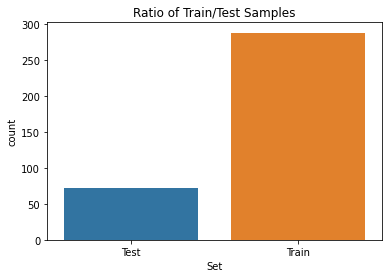

In [141]:
# visualize breakdown of train/test data samples using 80/20 split
sns.countplot(data=df, x='Set')
plt.title('Ratio of Train/Test Samples');

### Plot X-Ray Images

In [118]:
normal_images_train = list(paths.list_images(f"./Covid_Dataset/Train/Normal/"))
covid_images_train = list(paths.list_images(f"./Covid_Dataset/Train/Covid/"))

# Create function to display 5x5 grid of images
def plots_from_files(imspaths, figsize=(18,9), display_images=25, rows=1, cols=1, titles=None, maintitle=None):
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=40)
    #for i in range(len(imspaths)):
    for i in range(0, display_images):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

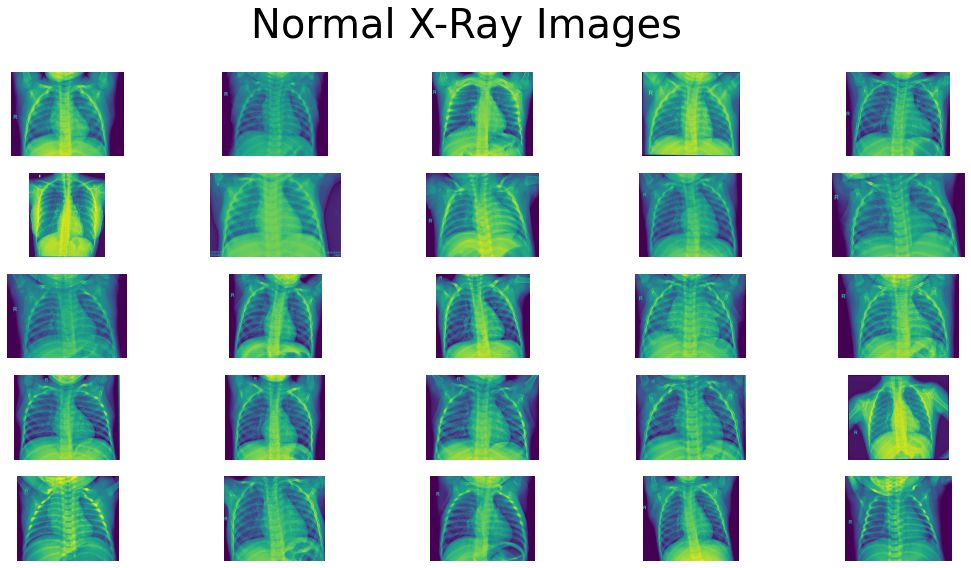

In [119]:
plots_from_files(normal_images_train, rows=5, cols=5, display_images=25, maintitle="Normal X-Ray Images")

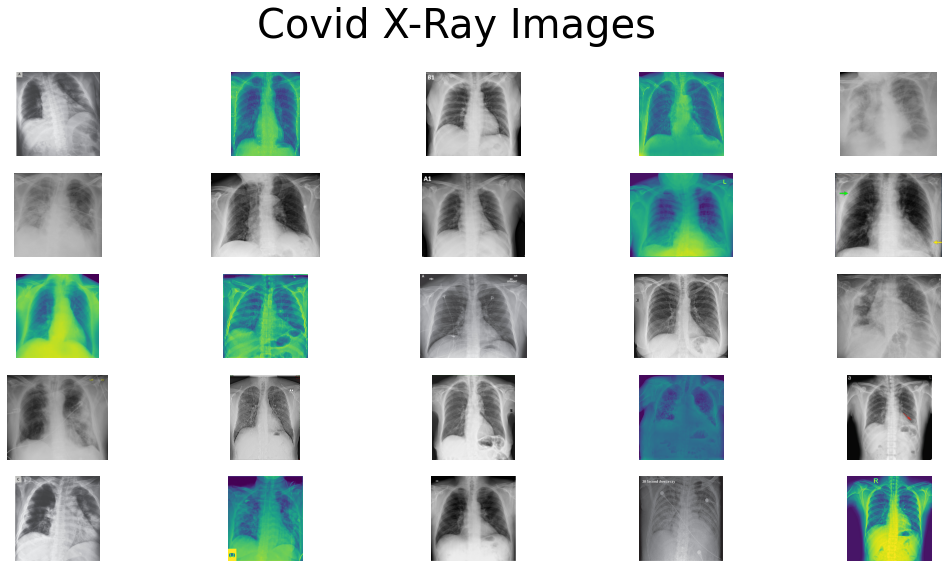

In [ ]:
plots_from_files(covid_images_train, rows=5, cols=5, display_images=25, maintitle="Covid X-Ray Images")

## Building a CNN Based Model in Keras

We will build a CNN starting with the standard 32 filters. The number of filters is increased with each layer, until reaching 128.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 54, 54, 64)       

## Train the Model Using the Images

In the following cells we will create a generator for both the train and test data subsets. For the the training data, various image augmentation methods will be used to account for variations in image makeup. The test data will simply be rescaled and normalized, without augmentation.

In [ ]:
# intialize number of epochs and batch size to train for
EPOCHS = 20
BS = 32

In [ ]:
# prepping & augmenting the images for loading into the model as inputs for training
train_data = image.ImageDataGenerator(
    rescale = 1./255, #normalize images
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [ ]:
test_data = image.ImageDataGenerator(rescale = 1./255)

In [ ]:
# converting image size, set the batch size (standard 224 by 224)
# feed the augmented images from previous step into the generator
train_generator = train_data.flow_from_directory(
    'Covid_Dataset/Train',
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary'
)

Found 288 images belonging to 2 classes.


In [ ]:
# print label for each class
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
test_generator = test_data.flow_from_directory(
    'Covid_Dataset/Test',
    target_size = (224,224),
    batch_size = BS,
    class_mode = 'binary'
)

Found 72 images belonging to 2 classes.


Finally, we will feed the processed images into the new CNN model. 10 Epochs coupled with 8 steps per epoch and 2 validation steps yields the greatest accuracy for the test and train performance.

In [ ]:
%%time

hist = model.fit_generator(
    train_generator,
    #steps_per_epoch = len(next(os.walk("./Covid_Dataset/Train/Covid/"))[2]) // BS,
    steps_per_epoch = 8,
    epochs = EPOCHS,
    validation_data = test_generator,
    validation_steps = 2
    #validation_steps = len(next(os.walk("./Covid_Dataset/Test/Covid/"))[2]) // BS
)

Epoch 1/20
8/8 [==============================] - 9s 1s/step - loss: 1.0076 - accuracy: 0.5391 - val_loss: 0.6757 - val_accuracy: 0.8281
Epoch 2/20
8/8 [==============================] - 9s 1s/step - loss: 0.5693 - accuracy: 0.7227 - val_loss: 0.4538 - val_accuracy: 0.8750
Epoch 3/20
8/8 [==============================] - 7s 892ms/step - loss: 0.4802 - accuracy: 0.7891 - val_loss: 0.4094 - val_accuracy: 0.9250
Epoch 4/20
8/8 [==============================] - 9s 1s/step - loss: 0.3567 - accuracy: 0.8633 - val_loss: 0.2670 - val_accuracy: 0.9531
Epoch 5/20
8/8 [==============================] - 9s 1s/step - loss: 0.2880 - accuracy: 0.9023 - val_loss: 0.2748 - val_accuracy: 0.9500
Epoch 6/20
8/8 [==============================] - 8s 945ms/step - loss: 0.3145 - accuracy: 0.9062 - val_loss: 0.2591 - val_accuracy: 0.9750
Epoch 7/20
8/8 [==============================] - 9s 1s/step - loss: 0.2909 - accuracy: 0.9141 - val_loss: 0.2873 - val_accuracy: 0.9688
Epoch 8/20
8/8 [===================

In [ ]:
# checkpoint to save highest accuracy
"""
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
"""

In [ ]:
# save the model to file
if os.path.exists("covid19_model_adv.h5"):
   os.remove("covid19_model_adv.h5")
   print("Previous model deleted.")
else :
   print("The file does not exist.")

model.save("covid19_model_adv.h5")
print("Most recent model saved as: covid19_model_adv.h5")

Previous model deleted.
Most recent model saved as: covid19_model_adv.h5


## Making Predictions from the Test Data

In [ ]:
model = load_model("covid19_model_adv.h5")

In [ ]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
y_actual = []
y_test = []

In [ ]:
for i in os.listdir("./Covid_Dataset/Test/Normal/"):
  img = image.load_img("./Covid_Dataset/Test/Normal/" + i, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(1)

In [ ]:
for i in os.listdir("./Covid_Dataset/Test/Covid/"):
  img = image.load_img("./Covid_Dataset/Test/Covid/" + i, target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  p = model.predict_classes(img)
  y_test.append(p[0,0])
  y_actual.append(0)

In [ ]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

## Model Evaluation

### Minimizing Loss & Maximizing Accuracy

Loss continuously decreased for training and validation progressively throughout each epoch. Similarly, accuracy increased progressively throughtout the training and vaidation process.

In [ ]:
model.evaluate_generator(train_generator)

[0.10033123195171356, 0.9513888955116272]

In [ ]:
model.evaluate_generator(test_generator)

[0.003818034427240491, 0.9583333134651184]

### Confusion Matrix

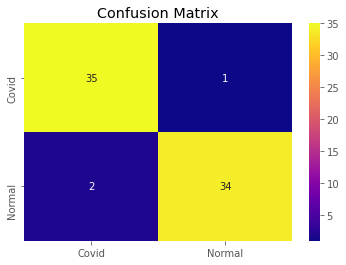

In [ ]:
cm = confusion_matrix(y_actual, y_test)
target_names = {'Covid': 0, 'Normal': 1}

ax = plt.axes()
sns.heatmap(cm, 
            cmap="plasma", 
            annot=True, 
            fmt='g', 
            yticklabels=target_names, 
            xticklabels=target_names)
ax.set_title('Confusion Matrix')
plt.show()

Based on the confusion matrix, we can make the following conclusions:

1.   **True Positives**: The model has correctly identified Covid Xrays under the Covid-19 class label with **97% accuracy**.
2.   **True Negatives**: The model has correctly identified non-Covid Xrays under the Normal (healthy) class label with **94% accuracy**.
3. **False Positives**: The model has incorrectly identified Covid Xrays under the Normal (healthy) class label with **0.05% inaccuracy**.
3. **False Negatives**: The model has incorrectly identified non-Covid Xrays under the Covid class label with **0.02% inaccuracy**.


### Classification Report

In [ ]:
print(classification_report(y_test, y_actual, target_names=target_names))
print("Precision score: {:.4f}".format(precision_score(y_actual, y_test)))
print("Recall score: {:.4f}".format(recall_score(y_actual, y_test)))
print("F1 Score: {:.4f}".format(f1_score(y_actual, y_test)))

              precision    recall  f1-score   support

       Covid       0.97      0.95      0.96        37
      Normal       0.94      0.97      0.96        35

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72

Precision score: 0.9714
Recall score: 0.9444
F1 Score: 0.9577


The classification report tells us the following:


*  The model is able to avoid labeling negative images as positive (precision), 96% of the time. That is, on average 96% of the predictions were correct.
* The model's ability to find all positive images (recall) is averaged at 96%.
*  The F1-score also indicates that 96% of positive predictions were correct.



### Plot the Training History

<Figure size 432x288 with 0 Axes>

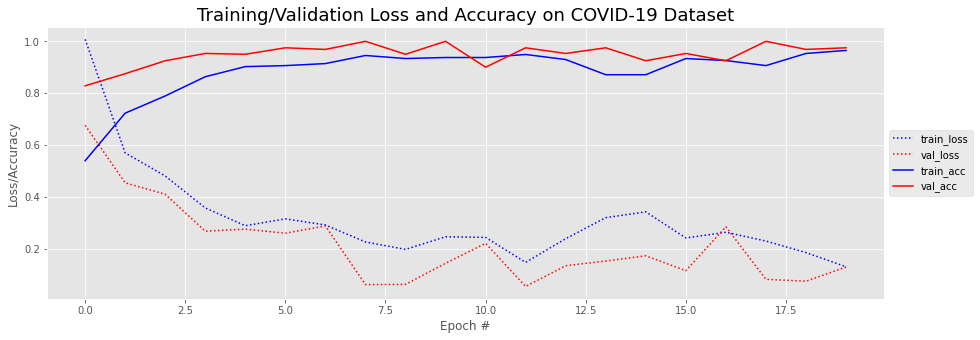

In [ ]:
# plot the training/validation loss and accuracy

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.figure(figsize=(15,5))
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss", color='blue', linestyle=':')
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss", color='red', linestyle=':')
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc", color='blue')
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc", color='red')
plt.title("Training/Validation Loss and Accuracy on COVID-19 Dataset", fontsize=18)
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':10})
plt.show()

Based on the training history plot above, it appears that the model does not overfit to the train data set.

### Using the model to classify a single image

The following code will pick an image from a specified directory and predict which class it should belong to. This can be used if building an application, whereby the user can upload an xray to be used for predictions.

In [ ]:
# Select random image and classify
# 0 = Covid, 1 = Normal
model = load_model("covid19_model_adv.h5")
random_image = random.choice(os.listdir("./Covid_Dataset/Test/Covid/"))
img = image.load_img("./Covid_Dataset/Test/Covid/" + random_image, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
p = model.predict_classes(x)
print(random_image, p)

covid-19-pneumonia-30-PA.jpg [[0]]


## Conclusion

The CNN model built in this project proved sufficient to classify images, based on a small training set. The accuracy was fairly strong at approximately 96%. However, in order to be used at a larger scale, a much larger training & test set should be used.

For further study, transfer learning could be used in order to have more data to work with.